# Building simple climate models using climlab

This notebook is part of [The Climate Laboratory](https://brian-rose.github.io/ClimateLaboratoryBook) by [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

____________
<a id='section1'></a>

## 1. Introducing climlab
____________


## About climlab

climlab {cite:p}`Rose:2018a` is a specialized python package for process-oriented climate modeling.

It is based on a very general concept of a model as a collection of individual, 
interacting processes. climlab defines a base class called `Process`, which
can contain an arbitrarily complex tree of sub-processes (each also some 
sub-class of `Process`). Every climate process (radiative, dynamical, 
physical, turbulent, convective, chemical, etc.) can be simulated as a stand-alone
process model given appropriate input, or as a sub-process of a more complex model. 
New classes of model can easily be defined and run interactively by putting together an
appropriate collection of sub-processes.

climlab is an open-source community project. The latest code can always be found on github:

https://github.com/brian-rose/climlab

## Installing climlab

If you've followed [these instructions from the Climate Laboratory book](https://brian-rose.github.io/ClimateLaboratoryBook/how-to.html), then you should be all set -- climlab is automatically installed as part of the suite of tools used in [The Climate Laboratory](https://brian-rose.github.io/ClimateLaboratoryBook).

If you are maintaining your own Python installation (e.g. on a personal laptop), you can always install climlab by doing

```
conda install -c conda-forge climlab
```

____________
<a id='section2'></a>

## 2. Using climlab to implement the zero-dimensional energy balance model
____________


### The model equation (recap)

Recall that we have worked with a zero-dimensional Energy Balance Model

$$ C \frac{dT_s}{dt} = (1-\alpha) Q - \tau \sigma T_s^4 $$ 

Here we are going to implement this exact model using climlab.

Yes, we have already written code to implement this model, but we are going to repeat this effort here as a way of learning how to use climlab.

There are tools within climlab to implement much more complicated models, but the basic interface will be the same.

### Create the state variables for the model

In [2]:
#  As usual, we start with some import statements.
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import climlab  # import climlab just like any other package

In [3]:
# create a zero-dimensional domain with a single surface temperature
state = climlab.surface_state(num_lat=1,  # a single point
                              water_depth = 100.,  # 100 meters slab of water (sets the heat capacity)
                             )
print(state)

AttrDict({'Ts': Field([[32.]])})


Here we have created a dictionary called `state` with a single item called `Ts`:

In [4]:
print(state['Ts'])

[[32.]]


This dictionary holds the state variables for our model -- which is this case is a single number!  It is a **temperature in degrees Celsius**.

For convenience, we can access the same data as an attribute (which lets us use tab-autocomplete when doing interactive work):

In [5]:
print(state.Ts)

[[32.]]


It is also possible to see this `state` dictionary as an `xarray.Dataset` object:

In [6]:
climlab.to_xarray(state)

<xarray.Dataset>
Dimensions:       (depth: 1, lat: 1, depth_bounds: 2, lat_bounds: 2)
Coordinates:
  * depth         (depth) float64 50.0
  * lat           (lat) float64 0.0
  * depth_bounds  (depth_bounds) float64 0.0 100.0
  * lat_bounds    (lat_bounds) float64 -90.0 90.0
Data variables:
    Ts            (depth, lat) float64 32.0

### Create the subcomponents of the model

In [7]:
delta_t = 60. * 60. * 24. * 30.  # 30 days, or about 1 month!

#  create the longwave radiation process
olr = climlab.radiation.Boltzmann(name='OutgoingLongwave',
                                  state=state, 
                                  tau = 0.612,
                                  eps = 1.,
                                  timestep = delta_t)
#  Look at what we just created
print(olr)

climlab Process of type <class 'climlab.radiation.boltzmann.Boltzmann'>. 
State variables and domain shapes: 
  Ts: (1, 1) 
The subprocess tree: 
OutgoingLongwave: <class 'climlab.radiation.boltzmann.Boltzmann'>



In [8]:
#  create the shortwave radiation process
asr = climlab.radiation.SimpleAbsorbedShortwave(name='AbsorbedShortwave',
                                                state=state, 
                                                insolation=341.3, 
                                                albedo=0.299,
                                                timestep = delta_t)
#  Look at what we just created
print(asr)

climlab Process of type <class 'climlab.radiation.absorbed_shorwave.SimpleAbsorbedShortwave'>. 
State variables and domain shapes: 
  Ts: (1, 1) 
The subprocess tree: 
AbsorbedShortwave: <class 'climlab.radiation.absorbed_shorwave.SimpleAbsorbedShortwave'>



### Create the model by coupling the subcomponents

In [9]:
#  couple them together into a single model
ebm = climlab.couple([olr,asr])
#  Give the parent process name
ebm.name = 'EnergyBalanceModel'
#  Examine the model object
print(ebm)

climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Ts: (1, 1) 
The subprocess tree: 
EnergyBalanceModel: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   OutgoingLongwave: <class 'climlab.radiation.boltzmann.Boltzmann'>
   AbsorbedShortwave: <class 'climlab.radiation.absorbed_shorwave.SimpleAbsorbedShortwave'>



The object called `ebm` here is the entire model -- including its current state (the temperature `Ts`) as well as all the methods needed to integrated forward in time!

The current model state, accessed two ways:

In [10]:
ebm.state

AttrDict({'Ts': Field([[32.]])})

In [11]:
ebm.Ts

Field([[32.]])

### Take a single timestep forward

Here is some internal information about the timestep of the model:

In [14]:
print(ebm.time['timestep'])
print(ebm.time['steps'])

2592000.0
0


This says the timestep is 2592000 seconds (30 days!), and the model has taken 0 steps forward so far.

To take a single step forward:

In [15]:
ebm.step_forward()

In [16]:
ebm.Ts

Field([[31.61786227]])

The model got colder!

To see why, let's look at some useful diagnostics computed by this model:

In [17]:
ebm.diagnostics

{'OLR': Field([[300.896072]]), 'ASR': 239.25130000000004}

This is another dictionary, now with two items. They should make sense to you.

Just like the `state` variables, we can access these `diagnostics` variables as attributes:

In [18]:
ebm.OLR

Field([[300.896072]])

In [19]:
ebm.ASR

239.25130000000004

So why did the model get colder in the first timestep?

What do you think will happen next?

____________
<a id='section3'></a>

## 3. Run the zero-dimensional EBM out to equilibrium
____________

Let's look at how the model adjusts toward its equilibrium temperature.

### Exercise

- Using a `for` loop, take 500 steps forward with this model
- Store the current temperature at each step in an array
- Make a graph of the temperature as a function of time

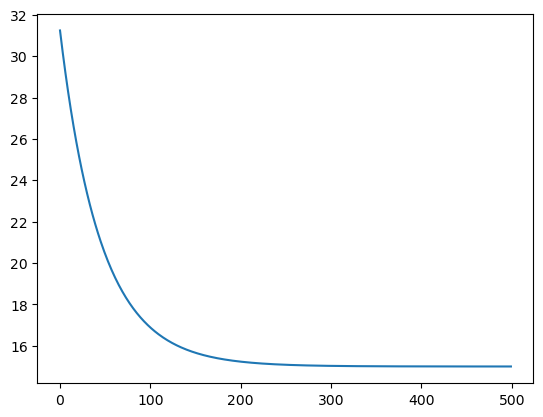

In [20]:
N = 500
Ts = np.zeros(N)
for i in range(N):
    ebm.step_forward()
    Ts[i] = ebm.Ts.item()

plt.plot(range(N), Ts)

____________
<a id='section4'></a>

## 4. A climate change scenario 
____________

### Description of the scenario

Suppose we want to investigate the effects of a small decrease in the transmissitivity of the atmosphere `tau`. 

Previously we used the zero-dimensional model to investigate a **hypothetical climate change scenario** in which:
- the transmissitivity of the atmosphere `tau` decreases to 0.57
- the planetary albedo increases to 0.32

### Implement the scenario in climlab

How would we do that using `climlab`?

Recall that the model is comprised of two sub-components:

In [21]:
for name, process in ebm.subprocess.items():
    print(name)
    print(process)

OutgoingLongwave
climlab Process of type <class 'climlab.radiation.boltzmann.Boltzmann'>. 
State variables and domain shapes: 
  Ts: (1, 1) 
The subprocess tree: 
OutgoingLongwave: <class 'climlab.radiation.boltzmann.Boltzmann'>

AbsorbedShortwave
climlab Process of type <class 'climlab.radiation.absorbed_shorwave.SimpleAbsorbedShortwave'>. 
State variables and domain shapes: 
  Ts: (1, 1) 
The subprocess tree: 
AbsorbedShortwave: <class 'climlab.radiation.absorbed_shorwave.SimpleAbsorbedShortwave'>



The parameter `tau` is a property of the `OutgoingLongwave` subprocess:

In [22]:
ebm.subprocess['OutgoingLongwave'].tau

0.612

and the parameter `albedo` is a property of the `AbsorbedShortwave` subprocess:

In [23]:
ebm.subprocess['AbsorbedShortwave'].albedo

0.299

Let's make an exact clone of our model and then change these two parameters:

In [24]:
ebm2 = climlab.process_like(ebm)
print(ebm2)

climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Ts: (1, 1) 
The subprocess tree: 
EnergyBalanceModel: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   OutgoingLongwave: <class 'climlab.radiation.boltzmann.Boltzmann'>
   AbsorbedShortwave: <class 'climlab.radiation.absorbed_shorwave.SimpleAbsorbedShortwave'>



In [25]:
ebm2.subprocess['OutgoingLongwave'].tau = 0.57
ebm2.subprocess['AbsorbedShortwave'].albedo = 0.32

Now our model is out of equilibrium and the climate will change!

To see this without actually taking a step forward:

In [26]:
#  Computes diagnostics based on current state but does not change the state
ebm2.compute_diagnostics()
ebm2.ASR - ebm2.OLR

Field([[9.25047414]])

Shoud the model warm up or cool down?

Well, we can find out:

In [27]:
ebm2.Ts

Field([[15.00324809]])

In [28]:
ebm2.step_forward()

In [29]:
ebm2.Ts

Field([[15.06059205]])

### Automatic timestepping

Often we want to integrate a model forward in time to equilibrium without needing to store information about the transient state.

`climlab` offers convenience methods to do this easily:

In [30]:
ebm3 = climlab.process_like(ebm2)

In [31]:
ebm3.integrate_years(50, )

Integrating for 608 steps, 18262.11 days, or 50 years.
Total elapsed time is 91.17237821916525 years.


In [32]:
#  What is the current temperature?
ebm3.Ts

Field([[17.94829599]])

In [33]:
#  How close are we to energy balance?
ebm3.ASR - ebm3.OLR

Field([[5.09500193e-05]])

In [34]:
#  We should be able to accomplish the exact same thing with explicit timestepping
#  And we could make a time-dependent plot too!
ebm4 = climlab.process_like(ebm2)

num_steps = 608
Tarray = np.zeros(num_steps)

for n in range(num_steps):
    ebm4.step_forward()
    Tarray[n] = ebm4.Ts

In [35]:
ebm4.Ts

Field([[17.94829599]])

In [36]:
ebm4.ASR - ebm4.OLR

Field([[5.09500193e-05]])

Looks like the same temperature and energy imbalance as we got above using `integrate_years` for auomatic timestepping.

But since we save the temperature from each timestep in variable `Tarray`, now we can make a plot:

Text(0, 0.5, 'Surface temperature (ºC)')

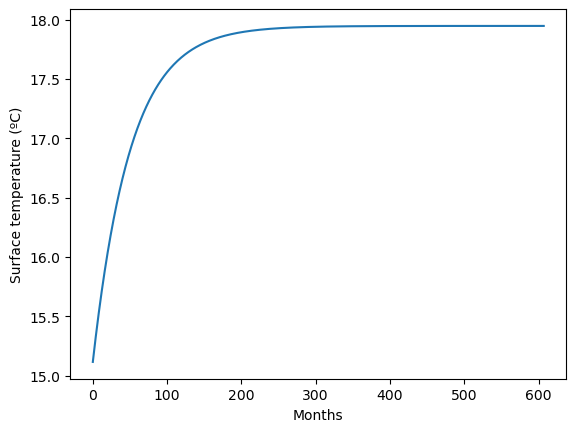

In [37]:
plt.plot(Tarray)
plt.xlabel('Months')
plt.ylabel('Surface temperature (ºC)')

____________
<a id='section5'></a>

## 5. Further `climlab` resources
____________

We will be using `climlab` extensively throughout this course. Lots of examples of more advanced usage are found here in the course notes. Here are some links to other resources:

- The documentation is hosted at <https://climlab.readthedocs.io/en/latest/>
- Source code (for both software and docs) are at <https://github.com/brian-rose/climlab>
- [A video of a talk I gave about `climlab` at the 2018 AMS Python symposium](https://ams.confex.com/ams/98Annual/videogateway.cgi/id/44948?recordingid=44948) (January 2018)
- [Slides from a talk and demonstration that I gave in Febrary 2018](https://livealbany-my.sharepoint.com/:f:/g/personal/brose_albany_edu/EuA2afxy5-hNkzNhHgkp_HYBYcJumR3l6ukRVIEl4W3MmA?e=sbXN0d) (The Apple Keynote version contains some animations that will not show up in the pdf version)

____________

## Credits

This notebook is part of [The Climate Laboratory](https://brian-rose.github.io/ClimateLaboratoryBook), an open-source textbook developed and maintained by [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

It is licensed for free and open consumption under the
[Creative Commons Attribution 4.0 International (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/) license.

Development of these notes and the [climlab software](https://github.com/brian-rose/climlab) is partially supported by the National Science Foundation under award AGS-1455071 to Brian Rose. Any opinions, findings, conclusions or recommendations expressed here are mine and do not necessarily reflect the views of the National Science Foundation.
____________